,Unix_Time,Interp_Temperature,Interp_Weight,Rssi,Device,Hive_Position,Sample,Battery,Temperature,Humidity,Scaled_Weight,Weight_Scale_Factor,Weight,w1,w3,w2,w4
0,1692514187,66.326604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1692514187,NaN,NaN,0.0,49:02:8D,Scale Under Hive,748.0,100.0,66.03,NaN,49.96,1.0,49.96,9.49,9.62,20.30,10.55
0,1692514187,NaN,49.578772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1692514487,NaN,49.573613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1692514487,66.456088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56825,1709561687,26.663770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56825,1709561687,NaN,93.743085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56826,1709561987,26.799971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56826,1709561987,NaN,93.739840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Done


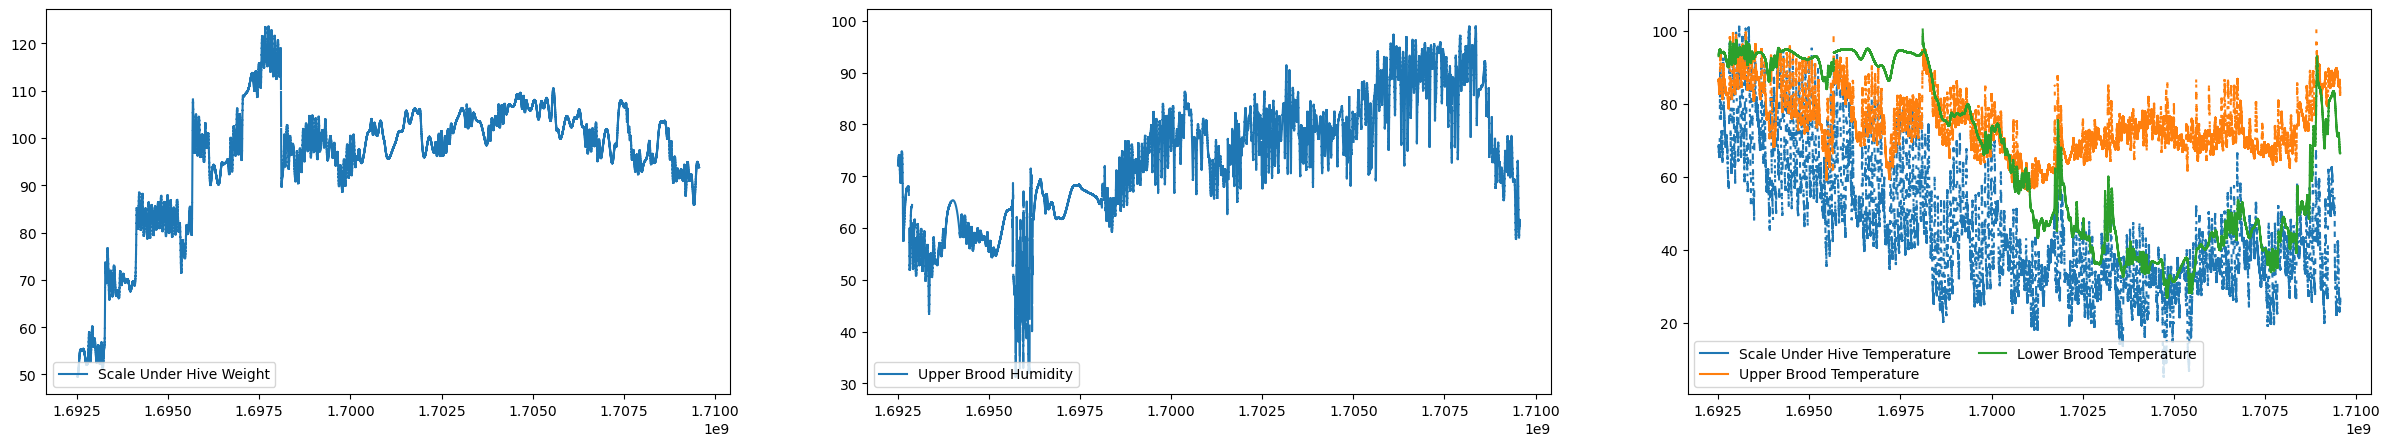

In [7]:
import os
import sys
sys.path.append("BEE_WEATHER_DATA")
from BEE_WEATHER_DATA import BROODMINDER_GET, AMBIENT_GET, BROODMINDER_PANDAS, READ_HIVE, READ_BEE_WEATHER
import pandas as pd
from glob import glob
import numpy as np
from scipy.interpolate import CubicSpline, UnivariateSpline
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

hive_name = "New Left Hive"

# Bee_Weather = READ_BEE_WEATHER()
# display(Bee_Weather)

def PROCESS_HIVE(hive_name):
    metrics = ["Weight", "Humidity", "Temperature"]
    Hive = READ_HIVE(hive_name)
    Unique_Dev_Names = Hive.Hive_Position.unique()
    Unique_Devs = Hive.Device.unique()
    Devices = {}
    Graph = 1
    for i, Device in enumerate(Unique_Devs):
        Devices.update({Unique_Dev_Names[i]: Hive[Hive['Device'] == Device]})
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 5))
    for j, metric in enumerate(metrics):
        for i, Device in enumerate(Unique_Devs):
            Devices[list(Devices.keys())[i]] = Devices[list(Devices.keys())[i]].sort_values(by=["Unix_Time"])
            # Resample and cubic-spline-interpolate to five minutes
            x = []
            y = []
            for k, value in enumerate(Devices[list(Devices.keys())[i]][str(metrics[j])]):
                if not np.isnan(value):
                    x.append(int(Devices[list(Devices.keys())[i]]["Unix_Time"].tolist()[k]))
                    y.append(value)
                    
            if not np.shape(x)[0] == 0:
                Temp_DF = pd.DataFrame()
                cs = UnivariateSpline(x, y)
                xs = np.arange(min(x), max(x), 300)
                Temp_DF["Unix_Time"] = xs
                Temp_DF[str('Interp_' + metrics[j])] = cs(xs)
                Devices[list(Devices.keys())[i]] = pd.concat([Temp_DF, Devices[list(Devices.keys())[i]]], axis=0, join='outer')
                Devices[list(Devices.keys())[i]] = Devices[list(Devices.keys())[i]].sort_values(by=["Unix_Time"])

                ax[j].plot(Devices[list(Devices.keys())[i]]["Unix_Time"], Devices[list(Devices.keys())[i]][str("Interp_" + metrics[j])], label=str(Unique_Dev_Names[i] + ' ' + metrics[j]))
                ax[j].legend(loc='lower left', ncol=2)
    
    return Devices

Devices = PROCESS_HIVE(hive_name)
# display(Devices["Scale Under Hive"])
    
def PROCESS_BEE_WEATHER():
    HiveWeather = HiveWeather.set_index('Unix_Time',drop = False)
    HiveWeather_upsampled = HiveWeather.resample('1s').mean()
    HiveWeather_interpolated = HiveWeather_upsampled[HiveWeather_upsampled.columns[1::]].interpolate(method='linear')
    HiveWeather_downsampled = HiveWeather_interpolated.resample('300s').mean()
    
print("Done")

In [2]:
metrics = ["Weight", "Humidity", "Temperature"]
np.isnan(Devices[list(Devices.keys())[1]][str("Interp_" + metrics[2])]).all()

True